# Retail EDA with Statistics and Linear Algebra

This notebook demonstrates exploratory data analysis (EDA) on a synthetic retail dataset.
We will cover: data inspection, cleaning, descriptive statistics, visualizations, statistical testing,
and linear algebra concepts (covariance, correlation, PCA via SVD/eigendecomposition).

## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from numpy.linalg import svd, eig

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

## 2. Create Synthetic Retail Dataset
We simulate a year of transactions across regions, stores, and product categories.
Includes noise, discounts, returns, and small missingness for realism.

In [11]:
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 1, 1)
days = (end_date - start_date).days
N = 5

dates = np.array([start_date + timedelta(days=int(d)) for d in np.random.randint(0, days, size=N)])
dates

array([datetime.datetime(2020, 12, 29, 0, 0),
       datetime.datetime(2020, 11, 25, 0, 0),
       datetime.datetime(2020, 12, 10, 0, 0),
       datetime.datetime(2021, 11, 6, 0, 0),
       datetime.datetime(2021, 2, 14, 0, 0)], dtype=object)

In [2]:
# Config
N = 5000  # number of transactions
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)
days = (end_date - start_date).days + 1

regions = ['North', 'South', 'East', 'West']
segments = ['Consumer', 'Corporate', 'Home Office', 'Small Business']
categories = ['Electronics', 'Clothing', 'Grocery', 'Home', 'Beauty', 'Sports', 'Toys', 'Books']
payment_methods = ['Cash', 'Card', 'Online']

# Base price by category (rough ranges)
cat_price_base = {
    'Electronics': 200, 'Clothing': 40, 'Grocery': 15, 'Home': 80,
    'Beauty': 25, 'Sports': 60, 'Toys': 30, 'Books': 20
}

# Generate columns
transaction_id = np.arange(1, N + 1)
dates = np.array([start_date + timedelta(days=int(d)) for d in np.random.randint(0, days, size=N)])
customer_id = np.random.randint(1000, 2000, size=N)
region = np.random.choice(regions, size=N, p=[0.28, 0.25, 0.23, 0.24])
store_id = np.random.randint(100, 200, size=N)
segment = np.random.choice(segments, size=N, p=[0.5, 0.2, 0.15, 0.15])
category = np.random.choice(categories, size=N, p=[0.18, 0.14, 0.2, 0.12, 0.1, 0.1, 0.08, 0.08])
payment = np.random.choice(payment_methods, size=N, p=[0.2, 0.55, 0.25])

# Price influenced by category + lognormal noise
base = np.vectorize(cat_price_base.get)(category).astype(float)
price = base * np.exp(np.random.normal(0, 0.35, size=N))

# Quantity skewed to small integers
quantity = np.clip(np.random.geometric(p=0.45, size=N), 1, 10)

# Discount levels
disc_levels = np.array([0.0, 0.05, 0.10, 0.15, 0.20])
disc_probs = np.array([0.45, 0.25, 0.16, 0.09, 0.05])
discount = np.random.choice(disc_levels, size=N, p=disc_probs)

gross = price * quantity
revenue = gross * (1 - discount)
cost = gross * np.random.uniform(0.5, 0.7, size=N)
profit = revenue - cost

returned = np.random.binomial(1, p=0.04, size=N).astype(bool)
# If returned, revenue and profit adjusted down (simple model)
revenue[returned] *= np.random.uniform(0.0, 0.5, size=returned.sum())
profit[returned] = revenue[returned] - cost[returned] * np.random.uniform(0.2, 0.5, size=returned.sum())

# Assemble DataFrame
df = pd.DataFrame({
    'transaction_id': transaction_id,
    'date': pd.to_datetime(dates),
    'customer_id': customer_id,
    'segment': segment,
    'region': region,
    'store_id': store_id,
    'category': category,
    'payment_method': payment,
    'price': price,
    'quantity': quantity,
    'discount': discount,
    'revenue': revenue,
    'cost': cost,
    'profit': profit,
    'returned': returned
})

# Introduce small missingness
mask_disc = np.random.rand(N) < 0.03
mask_seg = np.random.rand(N) < 0.02
df.loc[mask_disc, 'discount'] = np.nan
df.loc[mask_seg, 'segment'] = np.nan

df.sample(5, random_state=42)

,transaction_id,date,customer_id,segment,region,store_id,category,payment_method,price,quantity,discount,revenue,cost,profit,returned
1501,1502,2023-04-06,1038,Small Business,East,165,Home,Card,90.41,1,0.10,81.37,51.60,29.77,False
2586,2587,2023-09-12,1854,Consumer,East,186,Electronics,Card,86.65,3,0.00,259.94,150.19,109.75,False
2653,2654,2023-06-20,1446,Consumer,South,121,Electronics,Card,300.36,4,0.05,"1,141.37",620.37,521.01,False
1055,1056,2023-10-22,1315,Small Business,East,117,Beauty,Card,21.03,1,0.05,3.38,11.05,-1.77,True
705,706,2023-08-08,1381,Corporate,West,123,Clothing,Card,54.39,2,0.10,97.90,59.10,38.80,False


## 3. Data Overview & Quality Checks

In [3]:
print('Shape:', df.shape)
display(df.head())
print('Info:')
df.info(verbose=False)

print('Numeric summary:')
display(df.describe())

print('Categorical summary:')
display(df.select_dtypes(include='object').describe())

Shape: (5000, 15)


,transaction_id,date,customer_id,segment,region,store_id,category,payment_method,price,quantity,discount,revenue,cost,profit,returned
0,1,2023-04-13,1861,Home Office,West,175,Grocery,Card,29.88,4,NaN,107.55,67.11,40.44,False
1,2,2023-12-15,1567,NaN,South,113,Grocery,Online,16.46,5,0.05,78.19,43.86,34.34,False
2,3,2023-09-28,1059,Consumer,East,145,Clothing,Card,47.65,1,0.10,42.89,30.92,11.97,False
3,4,2023-04-17,1649,Small Business,North,114,Toys,Cash,28.12,2,0.00,56.23,34.82,21.41,False
4,5,2023-03-13,1038,Consumer,East,166,Electronics,Online,205.38,1,0.10,184.84,106.48,78.36,False


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 15 entries, transaction_id to returned
dtypes: bool(1), datetime64[ns](1), float64(5), int64(4), object(4)
memory usage: 551.9+ KB
Numeric summary:


,transaction_id,date,customer_id,store_id,price,quantity,discount,revenue,cost,profit
count,"5,000.00",5000,"5,000.00","5,000.00","5,000.00","5,000.00","4,851.00","5,000.00","5,000.00","5,000.00"
mean,"2,500.50",2023-07-01 12:02:35.520000,"1,499.07",148.76,69.52,2.22,0.05,139.65,91.23,50.69
min,1.00,2023-01-01 00:00:00,"1,000.00",100.00,4.62,1.00,0.00,0.03,3.08,-241.60
25%,"1,250.75",2023-04-03 00:00:00,"1,245.00",123.75,20.74,1.00,0.00,29.99,20.08,10.44
50%,"2,500.50",2023-06-28 00:00:00,"1,499.50",149.00,37.55,2.00,0.05,63.05,42.07,22.65
75%,"3,750.25",2023-10-01 00:00:00,"1,751.25",173.00,81.66,3.00,0.10,154.11,100.70,55.39
max,"5,000.00",2023-12-31 00:00:00,"1,999.00",199.00,604.96,10.00,0.20,"3,916.74","2,346.62","1,570.12"
std,"1,443.52",NaN,289.49,28.77,76.84,1.65,0.06,219.55,141.85,82.97


Categorical summary:


,segment,region,category,payment_method
count,4905,5000,5000,5000
unique,4,4,8,3
top,Consumer,North,Grocery,Card
freq,2479,1416,986,2753


In [4]:
# Missing values
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
display(pd.DataFrame({'missing': missing, 'percent': missing_pct}))

# Duplicates
print('Duplicate transaction_id count:', df.duplicated(subset=['transaction_id']).sum())

,missing,percent
discount,149,2.98
segment,95,1.90
transaction_id,0,0.00
date,0,0.00
customer_id,0,0.00
region,0,0.00
store_id,0,0.00
category,0,0.00
payment_method,0,0.00
price,0,0.00


Duplicate transaction_id count: 0


## 4. Univariate & Bivariate Exploration

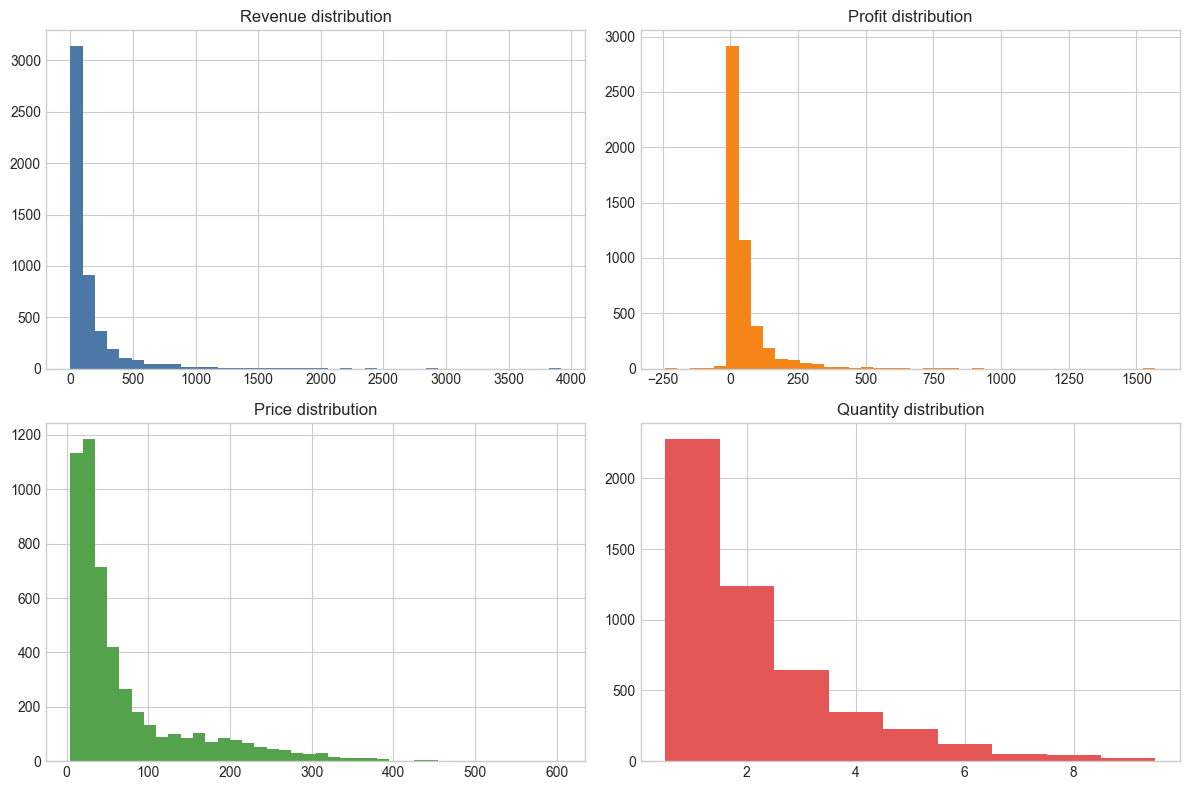

<Figure size 1000x500 with 0 Axes>

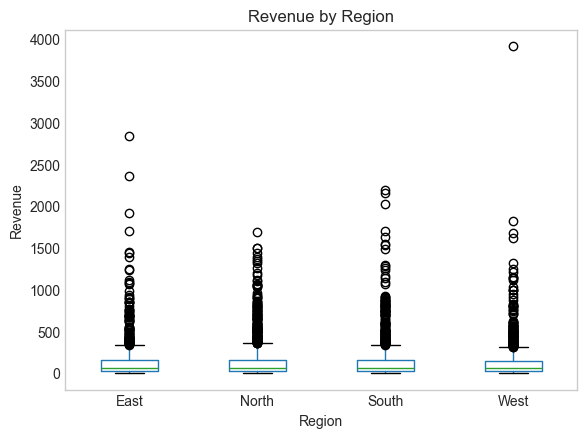

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
axes[0].hist(df['revenue'], bins=40, color='#4C78A8')
axes[0].set_title('Revenue distribution')
axes[1].hist(df['profit'], bins=40, color='#F58518')
axes[1].set_title('Profit distribution')
axes[2].hist(df['price'], bins=40, color='#54A24B')
axes[2].set_title('Price distribution')
axes[3].hist(df['quantity'], bins=np.arange(0.5, 10.5, 1), color='#E45756')
axes[3].set_title('Quantity distribution')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
df.boxplot(column='revenue', by='region', grid=False)
plt.title('Revenue by Region')
plt.suptitle('')
plt.xlabel('Region')
plt.ylabel('Revenue')
plt.show()

In [ ]:
# Grouped summaries
rev_by_cat = df.groupby('category')['revenue'].sum().sort_values(ascending=False)
rev_by_region = df.groupby('region')['revenue'].sum().sort_values(ascending=False)
profit_by_cat = df.groupby('category')['profit'].sum().sort_values(ascending=False)
display(rev_by_cat.head(10).to_frame('total_revenue'))
display(rev_by_region.to_frame('total_revenue'))
display(profit_by_cat.head(10).to_frame('total_profit'))

plt.figure(figsize=(10,4))
rev_by_cat.plot(kind='bar', color='#4C78A8')
plt.title('Total Revenue by Category')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()

## 5. RFM Features (Customer-Level)
Recency, Frequency, Monetary to segment customers for marketing/CRM.

In [ ]:
snapshot_date = df['date'].max() + pd.Timedelta(days=1)
cust_grp = df.groupby('customer_id', as_index=False).agg({
    'date': 'max',
    'transaction_id': 'count',
    'revenue': 'sum'
}).rename(columns={'transaction_id': 'frequency', 'revenue': 'monetary'})
cust_grp['recency'] = (snapshot_date - cust_grp['date']).dt.days
rfm = cust_grp[['customer_id', 'recency', 'frequency', 'monetary']].sort_values('monetary', ascending=False)
rfm.head()

## 6. Statistical Testing & Confidence Intervals
Example: compare mean order revenue between two regions using a permutation test (non-parametric).
Also compute an approximate 95% CI for the mean using normal approximation.

In [ ]:
# Pick two regions
a, b = 'North', 'South'
rev_a = df.loc[df['region'] == a, 'revenue'].values
rev_b = df.loc[df['region'] == b, 'revenue'].values

obs_diff = rev_a.mean() - rev_b.mean()
combined = np.concatenate([rev_a, rev_b])
n_a = len(rev_a)
B = 2000  # permutations
diffs = np.empty(B)
for i in range(B):
    np.random.shuffle(combined)
    diffs[i] = combined[:n_a].mean() - combined[n_a:].mean()
p_value = (np.abs(diffs) >= abs(obs_diff)).mean()

print(f'Observed mean difference ({a}-{b}): {obs_diff:,.2f}')
print(f'Permutation p-value: {p_value:.4f}')

# 95% CI for overall mean revenue (normal approx)
x = df['revenue'].values
mean = x.mean()
std = x.std(ddof=1)
n = len(x)
se = std / np.sqrt(n)
ci_low, ci_high = mean - 1.96*se, mean + 1.96*se
print(f'Mean revenue: {mean:,.2f}; 95% CI: [{ci_low:,.2f}, {ci_high:,.2f}]')

## 7. Correlation, Covariance, and PCA (Linear Algebra)
We build a standardized feature matrix, compute the covariance matrix as X^T X/(n-1),
then perform eigendecomposition and SVD to extract principal components.

In [ ]:
num_cols = ['price', 'quantity', 'discount', 'revenue', 'profit']
X_raw = df[num_cols].dropna().values  # drop rows with NaNs in selected features
mu = X_raw.mean(axis=0)
sigma = X_raw.std(axis=0, ddof=1)
X = (X_raw - mu) / sigma
n = X.shape[0]

# Covariance and correlation via linear algebra
Cov = (X.T @ X) / (n - 1)
std_vec = np.sqrt(np.diag(Cov))
Corr = Cov / np.outer(std_vec, std_vec)

print('Covariance matrix:
', pd.DataFrame(Cov, index=num_cols, columns=num_cols).round(3))
print('
Correlation matrix:
', pd.DataFrame(Corr, index=num_cols, columns=num_cols).round(3))

# Eigendecomposition (symmetric matrix)
eigvals, eigvecs = np.linalg.eigh(Cov)  # eigh for symmetric
idx = np.argsort(eigvals)[::-1]
eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]
explained_var = eigvals / eigvals.sum()
print('
Explained variance ratio (eigendecomposition):', np.round(explained_var, 3))

# SVD alternative
U, S, Vt = svd(X, full_matrices=False)
svd_explained = (S**2) / (n - 1)
svd_explained_ratio = svd_explained / svd_explained.sum()
print('Explained variance ratio (SVD):', np.round(svd_explained_ratio, 3))

# Project onto first 2 PCs
PCs = X @ eigvecs[:, :2]
plt.figure(figsize=(7,6))
plt.scatter(PCs[:,0], PCs[:,1], s=10, alpha=0.4, c='tab:blue')
plt.title('PCA Projection (PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 8. Outlier Detection (Z-scores)
Use standard z-scores to flag unusually high revenue transactions.

In [ ]:
rev = df['revenue'].values
z = (rev - rev.mean()) / rev.std(ddof=1)
outlier_mask = z > 3.0
print('Outliers (z>3):', outlier_mask.sum())
display(df.loc[outlier_mask, ['transaction_id','date','region','category','revenue','discount']].head(10))

plt.figure(figsize=(8,4))
plt.boxplot(df['revenue'], vert=False)
plt.title('Revenue Boxplot (Outliers visible)')
plt.xlabel('Revenue')
plt.show()

## 9. Time Series Summary
Aggregate revenue by month to observe seasonality or trends.

In [ ]:
df['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp()
m = df.groupby('year_month')['revenue'].sum()
display(m.to_frame('monthly_revenue'))

plt.figure(figsize=(10,4))
plt.plot(m.index, m.values, marker='o')
plt.title('Monthly Revenue')
plt.ylabel('Revenue')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 10. Notes & Next Steps
- Impute missing values (median for numeric, mode for categorical) before modeling.
- Extend tests: A/B tests by discount levels, seasonal decomposition, churn modeling.
- Enrich PCA: biplots, loadings interpretation, and clustering in PC space.